# Simulation errors and time limit

This notebook demonstrates how to catch errors and limit simulation time with the `unreliable_simulator` helper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import elfi

In [3]:
seed = 424050
random_state = np.random.RandomState(seed)

## Example 1

Assume this is a complex code that simulates task completion time.

In [4]:
def unreliable_worker(ave_time, num_tasks=10, random_state=None):
    if ave_time < 0.5:
        raise ValueError("ave time must exceed 0.5")
    random_state = random_state or np.random.RandomState()
    current_time = 0
    completed = 0
    while completed < num_tasks:
        task_completion_time = (ave_time-0.5) + random_state.exponential(0.5)
        if current_time + task_completion_time > 50:
            raise RuntimeError("worker collapsed")
        else:
            current_time += task_completion_time
            completed += 1
    return current_time

We can see that the code is unreliable.

In [5]:
unreliable_worker(5, random_state=random_state)

49.45281996600789

In [6]:
unreliable_worker(5, random_state=random_state)

RuntimeError: worker collapsed

Let us catch the runtime errors and have failed simulation runs return 0.

In [7]:
sim = elfi.tools.unreliable_operation(unreliable_worker, known_errors=RuntimeError, error_output=0)

In [8]:
sim(7)

Exception occurred: worker collapsed


0

We can now vectorise the simulator and run parameter inference:

In [9]:
sim_vec = elfi.tools.vectorize(sim)

In [10]:
obs = 20

In [11]:
m = elfi.ElfiModel(name='')
ave_time = elfi.Prior('uniform', 1, 5, model=m)
y = elfi.Simulator(sim_vec, ave_time, observed=[obs])
d = elfi.Distance('euclidean', y)

In [12]:
rej = elfi.Rejection(d, seed=seed)
res = rej.sample(10, quantile=0.1, bar=False)

Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed
Exception occurred: worker collapsed


In [13]:
res

Method: Rejection
Number of samples: 10
Number of simulations: 100
Threshold: 2.96
Parameter                Mean               2.5%              97.5%
ave_time:               1.989              1.308              2.536


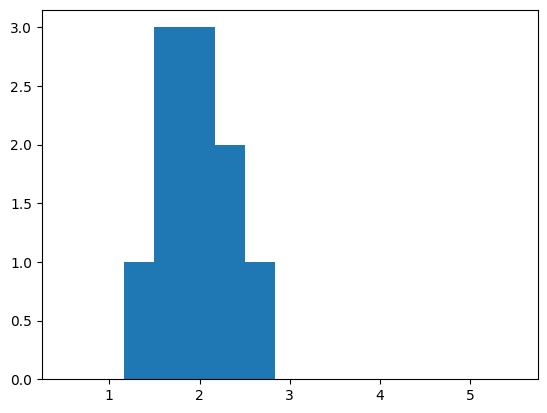

In [14]:
plt.hist(res.samples_array, range=(0.5, 5.5), bins=15);

## Example 2

Assume this is another complex code that simulates task completion time. 

In [15]:
import time

In [16]:
def slow_worker(ave_time, num_tasks=10, random_state=None):
    if ave_time < 0.5:
        raise ValueError("ave time must exceed 0.5")
    random_state = random_state or np.random.RandomState()
    completed_hours = 0
    completed_tasks = 0
    while completed_tasks < num_tasks:
        task_completion_time = (ave_time-0.5) + random_state.exponential(0.5)
        time.sleep(task_completion_time**2 / 100)
        completed_hours += task_completion_time
        completed_tasks += 1
    return completed_hours

Run inference with the new simulator:

In [17]:
y.become(elfi.Simulator(elfi.tools.vectorize(slow_worker), ave_time, observed=[obs]))

In [18]:
rej = elfi.Rejection(d, seed=seed)

In [19]:
%time res = rej.sample(10, quantile=0.1, bar=False)

CPU times: user 256 ms, sys: 36.8 ms, total: 293 ms
Wall time: 2min 48s


In [20]:
res

Method: Rejection
Number of samples: 10
Number of simulations: 100
Threshold: 2.96
Parameter                Mean               2.5%              97.5%
ave_time:               1.989              1.308              2.536


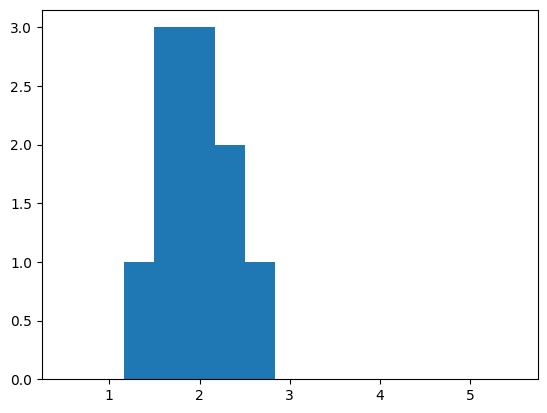

In [21]:
plt.hist(res.samples_array, range=(0.5, 5.5), bins=15);

The code worked as expected but it was slow. Assume we expected reasonable simulations to take less than a second. We can set a one-second limit on the simulations:

In [22]:
sim = elfi.tools.unreliable_operation(slow_worker, time_limit=1, error_output=0)

In [23]:
sim(7)

Operation exceeded time limit.


0

Run inference with the time-limited simulator:

In [24]:
y.become(elfi.Simulator(elfi.tools.vectorize(sim), ave_time, observed=[obs]))

In [25]:
rej = elfi.Rejection(d, seed=seed)

In [26]:
%time res = rej.sample(10, quantile=0.1, bar=False)

Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operation exceeded time limit.
Operatio

CPU times: user 390 ms, sys: 91.4 ms, total: 482 ms
Wall time: 1min 26s


In [27]:
res

Method: Rejection
Number of samples: 10
Number of simulations: 100
Threshold: 2.96
Parameter                Mean               2.5%              97.5%
ave_time:               1.989              1.308              2.536


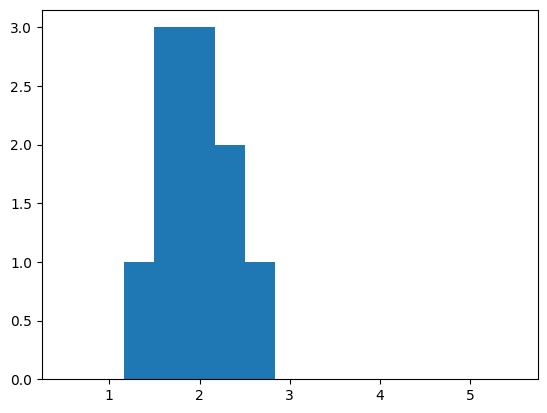

In [28]:
plt.hist(res.samples_array, range=(0.5, 5.5), bins=15);